# Conditional Gaussian Process Model Evaluation  #

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import dates, pyplot as plt
import stochasticdensity.gaussian_process_model as gpm
from bayesiankalman import mcmc
from pandas.tools.plotting import autocorrelation_plot

In [2]:
%matplotlib inline

In [3]:
plt.style.use('seaborn-talk')

In [95]:
results = mcmc.read_nested_hdf('../results/cond_gp_model.tmp.hdf')

In [96]:
estimates = {pd.to_datetime(key, format='%B_%d_%Y') : item for key, item in results['results'].items()}

In [97]:
entire_data = pd.DataFrame(results['data']['values'], index=results['data']['index'].astype('datetime64[s]'))

In [98]:
last_day = np.sort(list(estimates.keys()))[-1]

In [99]:
present_dates = np.unique(estimates[last_day]['dates'].astype('datetime64[D]'))
daily_returns = entire_data.groupby(pd.TimeGrouper('D')).sum().dropna().loc[present_dates]

## Setup ##

In [100]:
percentiles = (.1, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 99.9)

In [101]:
real_vols = entire_data.resample('5min').sum().apply(lambda x : x**2).groupby(pd.TimeGrouper('D')).sum().dropna().loc[present_dates]

In [102]:
if 'imeans' in estimates[last_day]:
    imeans_df = pd.DataFrame(estimates[last_day]['imeans'].T,index=present_dates)

In [103]:
if 'ivols' in estimates[last_day]:
    ivols_df = pd.DataFrame(estimates[last_day]['ivols'].T,index=present_dates)
    median_ivols = pd.DataFrame(np.median(ivols_df, axis=1), index=present_dates)

In [104]:
if 'ivols' in results:
    true_ivol_df = pd.DataFrame(results['ivols']['values'], present_dates)

## Evaluation ##

In [105]:
np.percentile(np.var(estimates[last_day]['imeans'], axis=1) / np.var(daily_returns.values), percentiles)

array([  9.36870883e-09,   1.58061063e-07,   1.41498547e-05,
         4.92734004e-05,   2.29299195e-04,   5.14712072e-04,
         8.68588918e-04,   1.40833471e-03,   2.07883446e-03,
         3.04204307e-03,   4.24821381e-03,   6.16042247e-03,
         8.20656582e-03,   1.31555884e-02,   1.87005925e-02])

In [106]:
mcmc.print_quantiles(estimates[last_day], ('imeans', 'ivols', 'noise_vars',
                                          'forecasted_ivols', 'forecasted_data','forecasted_imeans',
                                           'dates'), percentiles)

ivol_mean
   0.1th pct    1th pct    5th pct   10th pct   20th pct  30th pct  40th pct  \
0 -11.272281 -10.924049 -10.545688 -10.344544 -10.037255 -9.807165 -9.631038   

   50th pct  60th pct  70th pct  80th pct  90th pct  95th pct  99th pct  \
0 -9.466552  -9.31381 -9.141655 -8.915306 -8.629972 -8.431251 -7.875293   

   99.9th pct  
0   -7.655791  
imean_coeff
   0.1th pct  1th pct  5th pct  10th pct  20th pct  30th pct  40th pct  \
0        0.0      0.0      0.0       0.0       0.0       0.0       0.0   
1        0.0      0.0      0.0       0.0       0.0       0.0       0.0   
2        0.0      0.0      0.0       0.0       0.0       0.0       0.0   

   50th pct  60th pct  70th pct  80th pct  90th pct  95th pct  99th pct  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   99.9th pct  
0         0.0  
1   

In [107]:
np.mean(estimates[last_day]['fracdiff_accepted'])

0.63

In [108]:
np.mean(estimates[last_day]['data_loadings_accepted'])

0.90800000000000003

In [109]:
np.percentile(np.var(imeans_df, axis=0), percentiles)

array([  1.79513036e-12,   3.02859464e-11,   2.71124167e-09,
         9.44123450e-09,   4.39358244e-08,   9.86235440e-08,
         1.66429587e-07,   2.69849820e-07,   3.98323709e-07,
         5.82883295e-07,   8.13996649e-07,   1.18039333e-06,
         1.57245312e-06,   2.52073115e-06,   3.58320468e-06])

### Daily Returns ###

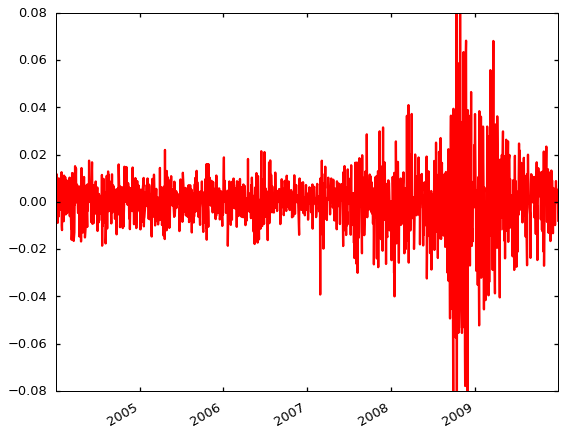

In [110]:
data_fig, data_ax = plt.subplots(1, 1)
data_ax.plot(daily_returns.loc[present_dates],color='red')
data_ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))
data_ax.set_ylim(-0.08, 0.08)
data_fig.set_size_inches(9, 7.5)
data_fig.autofmt_xdate()
data_fig.savefig('../paper/figures/data.tmp.png')

In [111]:
pd.DataFrame(np.corrcoef(estimates[last_day]['imean_coeff'].T, estimates[last_day]['imean_innov_var'].T))

0   1   2    3
0 NaN NaN NaN  NaN
1 NaN NaN NaN  NaN
2 NaN NaN NaN  NaN
3 NaN NaN NaN  1.0

In [112]:
pd.DataFrame(np.corrcoef(estimates[last_day]['ivol_coeff'].T, estimates[last_day]['fracdiff_coeff'].T))

0         1         2
0  1.000000  0.776625 -0.883329
1  0.776625  1.000000 -0.779341
2 -0.883329 -0.779341  1.000000

<a list of 20 Patch objects>

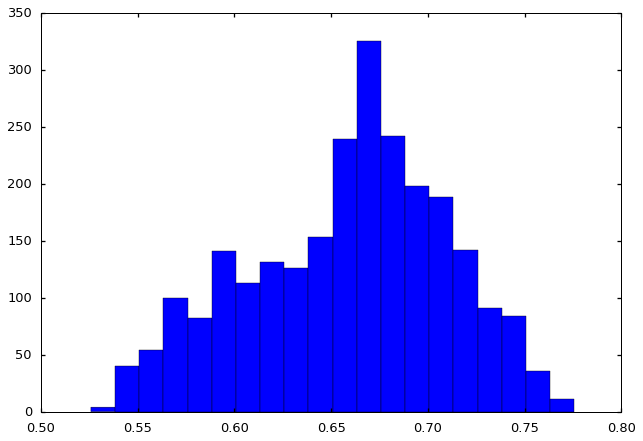

In [113]:
plt.hist(estimates[last_day]['fracdiff_coeff'], bins=20)[-1]

### Estimated Imeans Plot ###

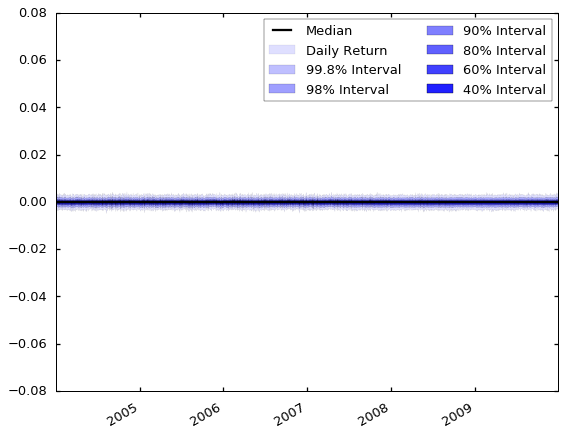

In [114]:
if 'imeans' in estimates[last_day]:
    imeans_est_fig, imeans_est_ax = plt.subplots(1,1)
    mcmc.fan_plot(imeans_est_ax, imeans_df,percentiles, c='black',
                  labels=['Median', 'Daily Return', '99.8% Interval', '98% Interval', '90% Interval', 
                         '80% Interval', '60% Interval', '40% Interval', '20% Interval'])

    if 'imeans' in results.keys():
        imean_est_xlimits = imeans_est_ax.get_lines()[0].get_xdata()
        imeans_est_ax.plot(imean_est_xlimits, results['imeans']['values'], label='True Value', c='red')
    imeans_est_ax.legend(ncol=2, loc='upper right')
    imeans_est_ax.set_ylim(-0.08, 0.08)
    imeans_est_fig.set_size_inches(9, 7.5)
    imeans_est_fig.autofmt_xdate()
    imeans_est_fig.savefig('../paper/figures/stochastic_means_estimated.tmp.png')

In [115]:
if 'imeans' in results.keys():
    differences = np.ravel(results['imeans']['values']) - np.median(imeans_df.values, axis=1)
    normed_diffs = differences / np.ravel(results['imeans']['values'])
    print("The median absolute normalized difference is " + str(np.median(np.abs(normed_diffs))))

### Ivols Est Plot ###

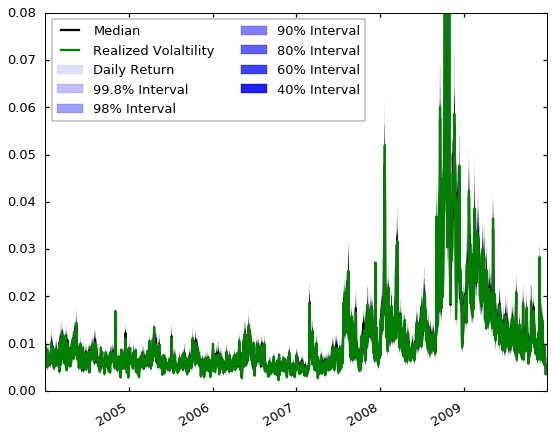

In [116]:
if 'ivols' in estimates[last_day]:
    ivols_est_fig, ivols_est_ax = plt.subplots(1,1)
    mcmc.fan_plot(ivols_est_ax, np.sqrt(ivols_df), percentiles, c='black', 
                 labels=['Median', 'Daily Return', '99.8% Interval', '98% Interval', '90% Interval', 
                         '80% Interval', '60% Interval', '40% Interval', '20% Interval'])
    ivols_est_xlimits = ivols_est_ax.get_lines()[0].get_xdata()
    if 'ivols' in results.keys():
        ivols_est_ax.plot(ivols_est_xlimits, np.sqrt(true_ivol_df), 'red', label='True Ivols')
    else:
        ivols_est_ax.plot(ivols_est_xlimits, np.sqrt(real_vols.loc[present_dates]),'green', 
                          label='Realized Volaltility')
    ivols_est_ax.legend(loc='upper left', ncol=2)
    plt.setp(ivols_est_ax.get_xticklabels(), rotation=0)
    ivols_est_ax.set_ylim(0, .08)
    ivols_est_fig.set_size_inches(9, 7.5)
    ivols_est_fig.autofmt_xdate()
    ivols_est_fig.savefig('../paper/figures/stochastic_vols_estimated.tmp.png')

In [117]:
if 'ivols' in results.keys():
    differences = real_vols.loc[present_dates].values.ravel() - np.median(ivols_df.values, axis=1)
    normed_diffs = differences / real_vols.loc[present_dates].values.ravel()
    print("The median normalized absolute difference is " + str(np.median(np.abs(normed_diffs))))

## Autocorrelation Plots ##

In [27]:
autocorrelation_plot(estimates[last_day]['fracdiff_coeff'])

<a list of 10 Patch objects>

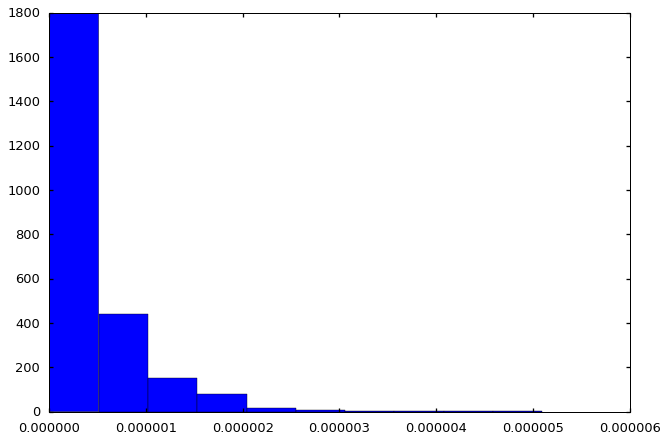

In [28]:
plt.hist(estimates[last_day]['imean_innov_var'])[-1]

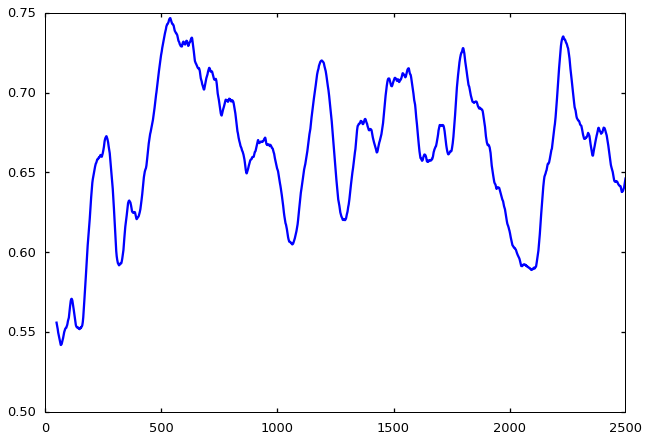

In [29]:
params = estimates[last_day]['fracdiff_coeff']
pd.DataFrame(params).rolling(50).mean().plot(legend=None)

## Forecasting ##

In [30]:
if 'forecasted_ivols' in estimates[last_day].keys():
    nsims, horizon = estimates[last_day]['forecasted_ivols'].shape
    forecast_data_df = pd.DataFrame(index=daily_returns.index, columns=np.arange(nsims), dtype='float')
    forecast_imeans_df = pd.DataFrame(index=daily_returns.index, columns=np.arange(nsims), dtype='float')
    forecast_ivols_df = pd.DataFrame(index=daily_returns.index, columns=np.arange(nsims), dtype='float')

In [31]:
if 'forecasted_ivols' in estimates[last_day].keys():
    for last_estimated_day, data in estimates.items():
        forecast_data, forecast_ivols, forecast_imeans = [data[key] for key in
                                                                ['forecasted_data', 'forecasted_ivols',
                                                                 'forecasted_imeans']]
        if last_estimated_day != last_day:
            future_date = daily_returns.loc[last_estimated_day:].index[horizon]
            forecast_data_df.loc[future_date] = np.sum(forecast_data[:,-1,:], axis=-1)
            forecast_ivols_df.loc[future_date] = forecast_ivols[:,-1]
            forecast_imeans_df.loc[future_date] = np.atleast_2d(forecast_imeans.T).T[:,-1]

In [32]:
if 'forecasted_ivols' in estimates[last_day].keys():
    future_dates = forecast_data_df.dropna().index
    future_data = daily_returns.loc[future_dates]

### Forecast Ivols Plot ###

In [81]:
if 'forecasted_ivols' in estimates[last_day].keys():
    ivols_fut_fig, ivols_fut_ax = plt.subplots(1,1)
    mcmc.fan_plot(ivols_fut_ax, pd.DataFrame(np.sqrt(forecast_ivols_df.dropna().values), future_dates), percentiles,
                        color='black', labels=['Median Forecast', 'Daily Return', '99.8% Forecast', '98% Forecast', 
                                               '90% Forecast', '80% Forecast', '60% Forecast', '40% Forecast', 
                                               '20% Forecast'])
    ivols_fut_xlimits = ivols_fut_ax.get_lines()[0].get_xdata()
    if 'ivols' in results.keys():
        ivols_fut_ax.plot(ivols_fut_xlimits, np.sqrt(true_ivol_df.loc[future_dates]), 'red', label='True Vols')
    else:
        ivols_fut_ax.plot(ivols_fut_xlimits, np.sqrt(np.median(ivols_df.loc[future_dates], axis=1)),'red', 
                         label='Median Estimate')
    ivols_fut_ax.legend(loc='upper right', ncol=2)
    ivols_fut_ax.set_ylim(0, 0.08)
    ivols_fut_fig.set_size_inches(9, 7.5)
    ivols_fut_fig.autofmt_xdate()
    ivols_fut_fig.savefig('../paper/figures/stochastic_vols_forecasted.tmp.png')

### Mean Return No Smoothing ###

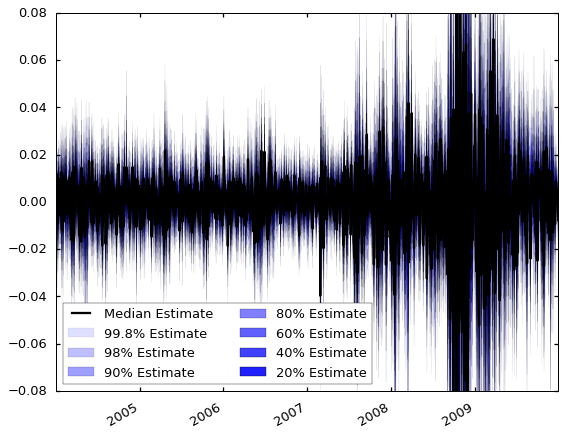

In [92]:
imean_no_smoothed_data = (daily_returns.values.T + (np.sqrt(ivols_df.loc[present_dates]).values * 
                                                    np.random.standard_normal(
            ivols_df.loc[present_dates].shape)).T).T

mean_est2_fig, mean_est2_ax = plt.subplots(1,1)

mcmc.fan_plot(mean_est2_ax, pd.DataFrame(imean_no_smoothed_data, present_dates), percentiles,
                        color='black', labels=['Median Estimate', '99.8% Estimate', '98% Estimate', 
                                               '90% Estimate', '80% Estimate', '60% Estimate', '40% Estimate', 
                                               '20% Estimate'])
mean_est2_ax.legend(loc='lower left', ncol=2)
mean_est2_ax.set_ylim([-0.08, 0.08])
mean_est2_fig.set_size_inches(9, 7.5)
mean_est2_fig.autofmt_xdate()
mean_est2_fig.savefig('../paper/figures/stochastic_means_estimated_no_smoothing.tmp.png')

### Forecast Data Plot ### 

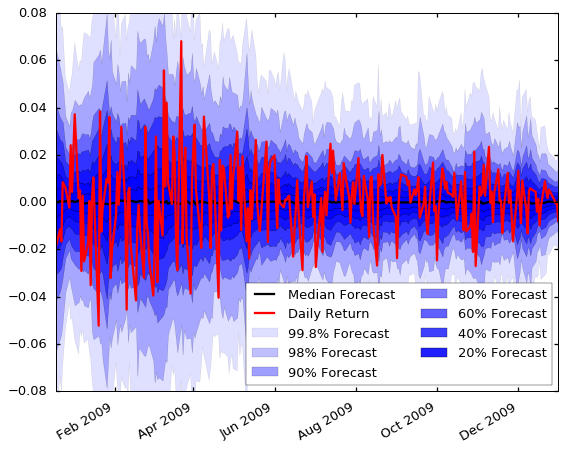

In [82]:
if 'forecasted_ivols' in estimates[last_day].keys():
    data_pred_fig, data_pred_ax = plt.subplots(1,1)
    mcmc.fan_plot(data_pred_ax, forecast_data_df.dropna(), percentiles,color='black')
    data_pred_xlimits = data_pred_ax.get_lines()[0].get_xdata()
    data_pred_ax.plot(data_pred_xlimits, future_data.loc[future_dates].values,'red')
    data_pred_ax.legend(['Median Forecast', 'Daily Return', '99.8% Forecast', '98% Forecast', '90% Forecast', 
                         '80% Forecast', '60% Forecast', '40% Forecast', '20% Forecast'], ncol=2, loc='lower right')
    data_pred_ax.set_ylim(-0.08, 0.08)
    data_pred_fig.set_size_inches(9, 7.5)
    data_pred_fig.autofmt_xdate()
    data_pred_fig.savefig('../paper/figures/stochastic_density_forecasted.tmp.png')

In [36]:
if 'forecasted_ivols' in estimates[last_day].keys():
    est_imeans = pd.DataFrame(np.median(estimates[last_day]['imeans'],0),
                          index=estimates[last_day]['dates'].astype('datetime64[D]'))

In [37]:
if 'imeans' in results:
    true_imeans_df = pd.DataFrame(results['imeans']['values'], results['imeans']['index'].astype('datetime64[s]'))

### Forecast Mean Plot ###

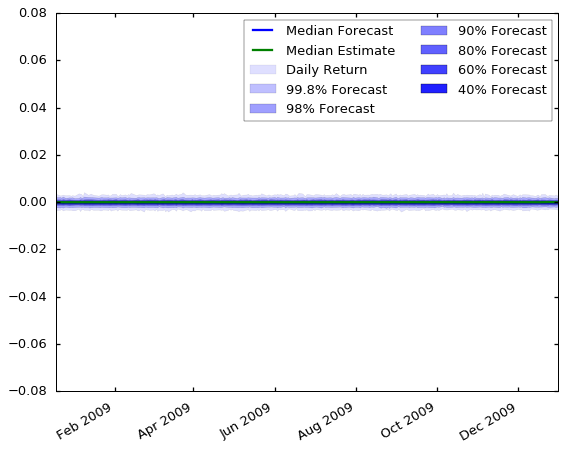

In [84]:
if 'forecasted_ivols' in estimates[last_day].keys():
    imeans_pred_fig, imeans_pred_ax = plt.subplots(1,1)
    mcmc.fan_plot(imeans_pred_ax, forecast_imeans_df.loc[future_dates], percentiles, 
                 labels=['Median Forecast', 'Daily Return', '99.8% Forecast', '98% Forecast', '90% Forecast', 
                         '80% Forecast', '60% Forecast', '40% Forecast', '20% Forecast'])
    imeans_pred_xlimits = imeans_pred_ax.get_lines()[0].get_xdata()
    if 'imeans' in results:
        imeans_pred_ax.plot(imeans_pred_xlimits, true_imeans_df.loc[future_dates], 'red', label='True Mean')
    else:
        imeans_pred_ax.plot(imeans_pred_xlimits, est_imeans.loc[future_dates].values,'green', 
                            label='Median Estimate')
    imeans_pred_ax.legend(ncol=2)
    imeans_pred_ax.set_ylim(-0.08, 0.08)
    imeans_pred_fig.set_size_inches(9, 7.5)
    imeans_pred_fig.autofmt_xdate()
    imeans_pred_fig.savefig('../paper/figures/stochastic_means_forecasted.tmp.png')

In [39]:
if 'forecasted_ivols' in estimates[last_day].keys():    
    data_pit = mcmc.probability_integral_transform(forecast_data_df.dropna().values, future_data.values)

### Data PIT ### 

In [119]:
len(data_pit)

260

In [40]:
if 'forecasted_ivols' in estimates[last_day].keys():
    data_pit_fig, data_pit_ax = plt.subplots(1,1)
    pd.DataFrame(data_pit).plot(kind='density', ax=data_pit_ax, legend=None, color='g', bw_method='scott')
    data_pit_ax.hist(data_pit, normed=True, bins=8, color='b')
    data_pit_ax.set(xlim=[0,1], ylabel="")  
    data_pit_fig.set_size_inches(9, 7.5)
    data_pit_fig.savefig('../paper/figures/stochastic_density_pit.tmp.png')

In [41]:
if 'forecasted_ivols' in estimates[last_day].keys():
    print(stats.kstest(data_pit.ravel(), 'uniform'))

KstestResult(statistic=0.075384615384615383, pvalue=0.098918119794607406)


In [42]:
if 'forecasted_ivols' in estimates[last_day].keys():
    autocorrelation_plot(data_pit)
    plt.ylabel("")
    plt.gcf().set_size_inches(9, 7.5)
    plt.savefig('../paper/figures/stochastic_density_pit_autocorr.tmp.png')

In [43]:
if 'forecasted_ivols' in estimates[last_day].keys():
    if 'ivols' in results:
        ivols_pit = mcmc.probability_integral_transform(forecast_ivols_df.dropna().values, 
                                                    true_ivol_df.loc[future_dates].values)
    else: 
        ivols_pit = mcmc.probability_integral_transform(forecast_ivols_df.dropna().values, 
                                                    np.median(ivols_df.loc[future_dates].values, axis=1))

In [44]:
if 'forecasted_ivols' in estimates[last_day].keys():
    print(stats.kstest(ivols_pit.ravel(), 'uniform'))

KstestResult(statistic=0.079846153846153872, pvalue=0.068752088932364952)


### Ivols PIT ### 

In [45]:
if 'forecasted_ivols' in estimates[last_day].keys():
    ivols_pit_fig, ivols_pit_ax = plt.subplots(1,1)
    pd.DataFrame(ivols_pit).plot(kind='density', ax=ivols_pit_ax, legend=None, color='g', bw_method='scott')
    ivols_pit_ax.hist(ivols_pit, normed=True, bins=8, color='b')
    ivols_pit_ax.set(xlim=[0,1], ylabel="")  
    ivols_pit_fig.set_size_inches(9, 7.5)
    ivols_pit_fig.savefig('../paper/figures/stochastic_vols_pit.tmp.png')

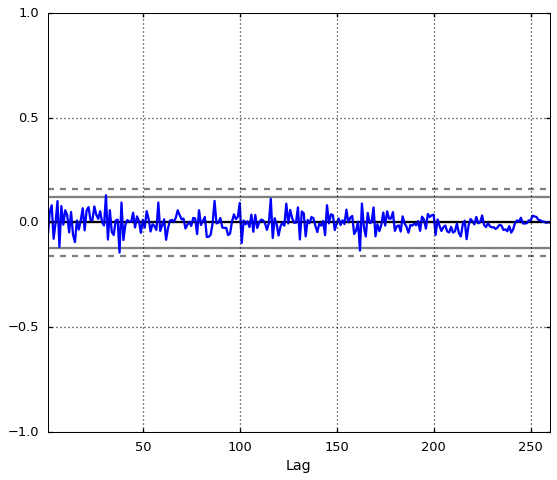

In [46]:
if 'forecasted_ivols' in estimates[last_day].keys():
    autocorrelation_plot(ivols_pit)
    plt.ylabel("")
    plt.gcf().set_size_inches(9, 7.5)
    plt.savefig('../paper/figures/stochastic_vols_pit_autocorr.tmp.png')

In [47]:
if 'forecasted_ivols' in estimates[last_day].keys():
    if 'imeans' in results.keys():
        imeans_pit = mcmc.probability_integral_transform(forecast_imeans_df.dropna().values, 
                                                         results['imeans']['values'])
    else:
        imeans_pit = mcmc.probability_integral_transform(forecast_imeans_df.dropna().values, 
                                                         np.median(imeans_df.loc[future_dates], axis=0))

In [48]:
if 'forecasted_ivols' in estimates[last_day].keys():
    print(stats.kstest(imeans_pit.ravel(), 'uniform'))

KstestResult(statistic=0.34766153846153847, pvalue=0.0)


### Imean Pit ###

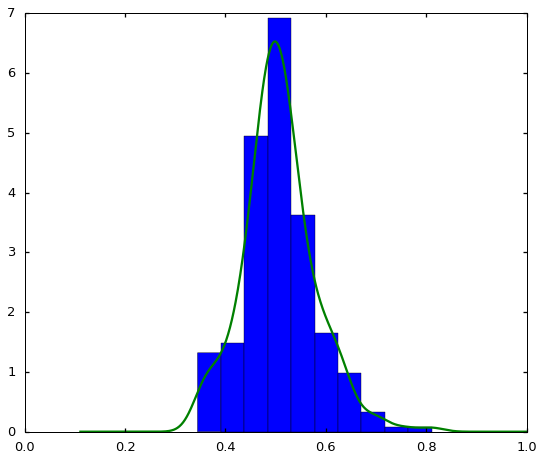

In [49]:
if 'forecasted_ivols' in estimates[last_day].keys():
    imeans_pit_fig, imeans_pit_ax = plt.subplots(1,1)
    pd.DataFrame(imeans_pit).plot(kind='density', ax=imeans_pit_ax, legend=None, color='g', bw_method='scott')
    imeans_pit_ax.hist(imeans_pit, normed=True, bins=10, color='b')
    imeans_pit_ax.set(xlim=[0,1], ylabel="")  
    imeans_pit_fig.set_size_inches(9, 7.5)
    imeans_pit_fig.savefig('../paper/figures/stochastic_means_pit.tmp.png')

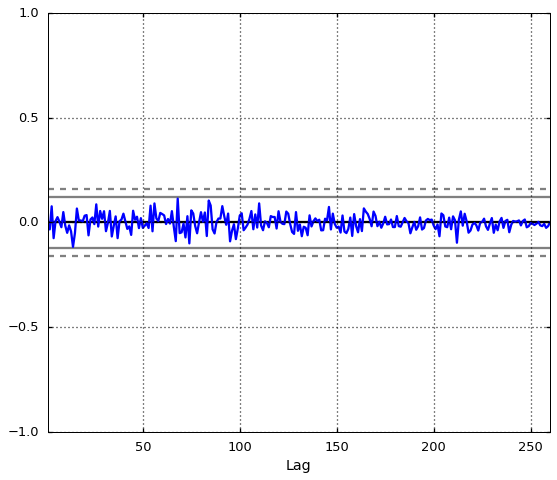

In [50]:
if 'forecasted_ivols' in estimates[last_day].keys():
    autocorrelation_plot(imeans_pit)
    plt.ylabel("")
    plt.gcf().set_size_inches(9, 7.5)
    plt.savefig('../paper/figures/stochastic_means_pit_autocorr.tmp.png')